In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
! mkdir kaggle
if not os.listdir('kaggle'):
    ! kaggle datasets download -p kaggle --unzip olistbr/brazilian-ecommerce

In [ ]:
os.listdir('kaggle')

## Order_dataset analysis

In [ ]:
order = pd.read_csv('kaggle\olist_orders_dataset.csv')

In [5]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [6]:
order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


First check datatypes

In [7]:
order.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [8]:
order.order_status.value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

For now we can keep order status unavailable, but it is candidate to be changed into nan.
We will drop rows with not significant values, that do not inform us if and when an order was delivered.

In [9]:
order = order[~order.order_status.isin(['approved', 'created', 'processing', 'invoiced'])]

Transforming columns to date format and adding new column order_delay:
* order_delay = order_delivered_customer_date - order_estimated_delivery_date
We will also remove time, transforming it to 00:00:00 beacuse such precision is not necessary

In [10]:
order.order_status = order.order_status.astype('category')

In [11]:
order['purchased'] = order['order_purchase_timestamp'].astype('datetime64[ns]').dt.normalize()
order['approved'] = order['order_approved_at'].astype('datetime64[ns]').dt.normalize()
order['carrier_delivered'] = order['order_delivered_carrier_date'].astype('datetime64[ns]').dt.normalize()
order['delivered'] = order['order_delivered_customer_date'].astype('datetime64[ns]').dt.normalize()
order['estimated'] = order['order_estimated_delivery_date'].astype('datetime64[ns]').dt.normalize()

In [12]:
order = order.drop(labels=['order_estimated_delivery_date', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at', 'order_purchase_timestamp'], axis=1)

Looks like nans are due to orders still being processed

In [13]:
order.isna().sum()

order_id                0
customer_id             0
order_status            0
purchased               0
approved              155
carrier_delivered    1161
delivered            2343
estimated               0
dtype: int64

**Nans in approved column**

Orders status is mostly cancelled. There are few that have nans in approved, but are correctly delivered, it may be logging software issue.

In [14]:
temp = order[order['approved'].isna()]
temp['order_status'].value_counts()
temp[temp['order_status']=='delivered'].head(14)
del temp

**Nans in carrier_delivered column**

Half of these orders are canceled

Other hals has unavailable order status. These orders are only approved, but not delivered, their dates range from 2016-10-05 to 2018-08-21, so they are not in processing, maybe there were other problems with these orders, that are not registered as cancellation.

There are two orders that are marked as delivered, but they look like errors in software

In [15]:
temp = order[order['carrier_delivered'].isna()]
temp['order_status'].value_counts()
temp[temp['order_status']=='unavailable'].head()#['purchased'].max()#.min()
temp[temp['order_status']=='delivered']
del temp

**Nans in delivered column**

There are many nans coorelated with nans in preceding columns

Other orders are sent to customers, but not delivered. Looking at purchased and estimated dates distributions, these orders are not still processing. Maybe the customer has to manually confirm receipt of the order, but these orders make only 1.12% of all orders, so it is unlikely.

1.1202299152996893


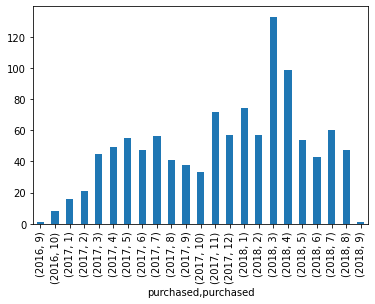

In [16]:
temp = order[order['delivered'].isna()]
temp = temp[temp['order_status']=='shipped']

temp.groupby([temp['purchased'].dt.year, temp['purchased'].dt.month])['order_id'].count().plot(kind="bar")
print((len(temp) / len(order)) * 100)
del temp

Now let's analyze how long customers wait for orders compared to how long we estimate they will wait.

In [17]:
order['days_diff'] = (order['delivered']-order['estimated']).dt.days

Looks like orders are delivered before estimated time. This is good, the software probably artificially inflates estimated time to be sure orders won't be late.
However, there are significant outliers.

In [18]:
order.days_diff.describe()

count    96476.000000
mean       -11.876881
std         10.183854
min       -147.000000
25%        -17.000000
50%        -12.000000
75%         -7.000000
max        188.000000
Name: days_diff, dtype: float64

Outliers look like correct rows.

In [19]:
# order[order.days_diff<-100].head()
order[order.days_diff>100].head()

,order_id,customer_id,order_status,purchased,approved,carrier_delivered,delivered,estimated,days_diff
3202,4f39a94d6e474819d898d6df7d394996,27a410dccb395b6ce45963874d158352,delivered,2017-04-28,2017-04-29,2017-05-09,2017-09-19,2017-05-30,112.0
4666,b31c7dea63bb08f8cdd1ec32514ccf0b,2a351c540a0cbdd0d9c266626f6d3acc,delivered,2017-09-26,2017-09-26,2017-09-29,2018-02-05,2017-10-19,109.0
11399,47b40429ed8cce3aee9199792275433f,cb2caaaead400c97350c37a3fc536867,delivered,2018-01-03,2018-01-03,2018-02-06,2018-07-13,2018-01-19,175.0
12813,c2a550cc5f966506b717532441c221e5,fc99aeadad12e8925f558305956a08aa,delivered,2018-01-12,2018-01-13,2018-01-15,2018-05-23,2018-02-08,104.0
16945,cce224811ba8fea016c049693c3e0402,919dc37f94a27a8b5cac7fd53291afd4,delivered,2018-02-28,2018-02-28,2018-03-02,2018-07-26,2018-03-22,126.0


**To do**: see if anomalies in data are correlated with other variables from different tables, e.g.:
* order.days_diff outliers and geographical location
* 